In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics,cluster,mixture,datasets,decomposition,preprocessing,feature_extraction
from sklearn.manifold import TSNE

## 加载数据

In [2]:
digits = datasets.load_digits()
digits_data = preprocessing.scale(digits.data)
digits_labels = digits.target

n_digits = len(np.unique(digits.target))
n_samples, n_features = digits_data.shape
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


In [3]:
news = datasets.fetch_20newsgroups()

vectorizer = feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=10000,
                                min_df=2, stop_words='english', use_idf=True)
news_data = vectorizer.fit_transform(news.data)
# 降维 100维, 只取前1/10数据集
tsvd = decomposition.TruncatedSVD(n_components=100)
news_data = tsvd.fit(news_data.transpose()).components_.transpose()
news_labels = news.target
news_data = news_data[::10]
news_labels = news_labels[::10]

n_groups = len(np.unique(news.target))
n_samples, n_features = news_data.shape
print("n_groups: %d, \t n_samples %d, \t n_features %d"
      % (n_groups, n_samples, n_features))

n_groups: 20, 	 n_samples 1132, 	 n_features 100


## 降维数据用于可视化

In [4]:
tsne = TSNE(n_components=2)
digits_data_2d = tsne.fit_transform(digits_data)
news_data_2d = tsne.fit_transform(news_data)

In [5]:
def visualize(data, labels):
    x = []
    y = []
    for i in data:
        x.append(i[0])
        y.append(i[1])
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(x, y, c=labels)
    plt.xticks(())
    plt.yticks(())
    plt.show()

## 评估

In [6]:
def bench(estimator, data, labels):
    print('time\t\tNMI\t\thomogeneity\t\tcompleteness')
    t0 = time()
    estimator.fit(data)
    print('%.2fs\t\t%.3f\t\t%.3f\t\t\t%.3f'
          % ((time() - t0),
             metrics.normalized_mutual_info_score(labels, estimator.labels_, average_method='arithmetic'),
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_)))
    
def gaussianbench(estimator, data, labels):
    print('time\t\tNMI\t\thomogeneity\t\tcompleteness')
    t0 = time()
    estimator.fit(data)
    labels_ = estimator.predict(data)
    print('%.2fs\t\t%.3f\t\t%.3f\t\t\t%.3f'
          % ((time() - t0),
             metrics.normalized_mutual_info_score(labels, labels_, average_method='arithmetic'),
             metrics.homogeneity_score(labels, labels_),
             metrics.completeness_score(labels, labels_)))

#### digits

In [7]:
methods = [
    cluster.KMeans(init='k-means++', n_clusters=n_digits),
    cluster.AffinityPropagation(),
    cluster.MeanShift(bandwidth=0.3,min_bin_freq=5),
    cluster.hierarchical.AgglomerativeClustering(n_clusters=n_digits),
    cluster.hierarchical.AgglomerativeClustering(n_clusters=n_digits, linkage='average'),
    cluster.DBSCAN(eps=1,min_samples=1),
    mixture.GaussianMixture(n_components=n_digits),
]

***************************************************************************
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
------------------------------ digits ------------------------------
time		NMI		homogeneity		completeness
0.57s		0.623		0.600			0.647


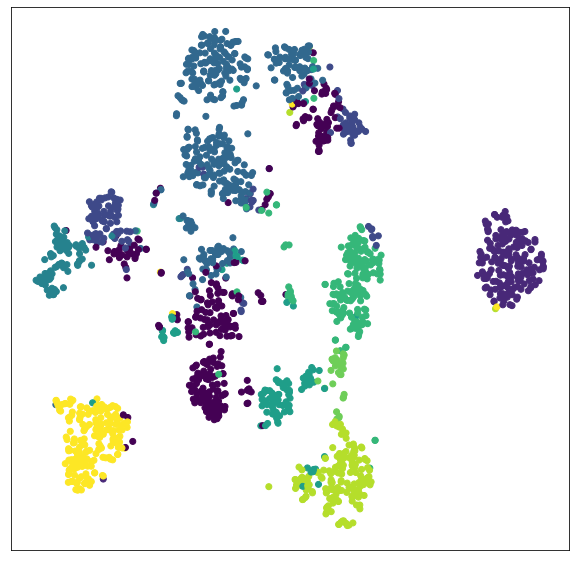

***************************************************************************
AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)
------------------------------ digits ------------------------------
time		NMI		homogeneity		completeness
8.02s		0.616		0.932			0.460


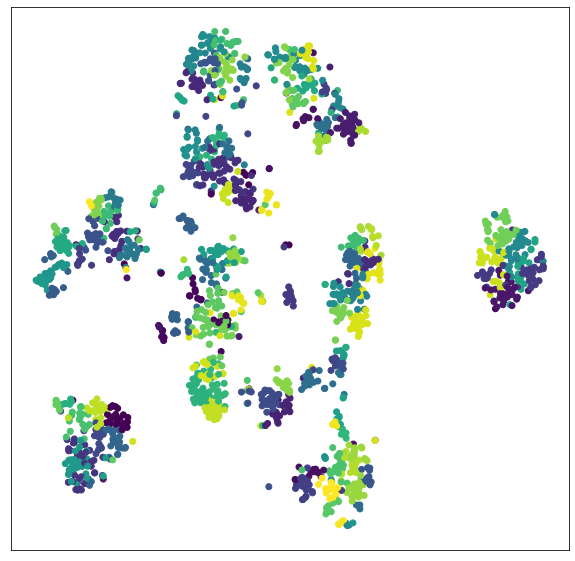

***************************************************************************
MeanShift(bandwidth=0.3, bin_seeding=False, cluster_all=True, min_bin_freq=5,
          n_jobs=None, seeds=None)
------------------------------ digits ------------------------------
time		NMI		homogeneity		completeness
4.36s		0.470		1.000			0.307


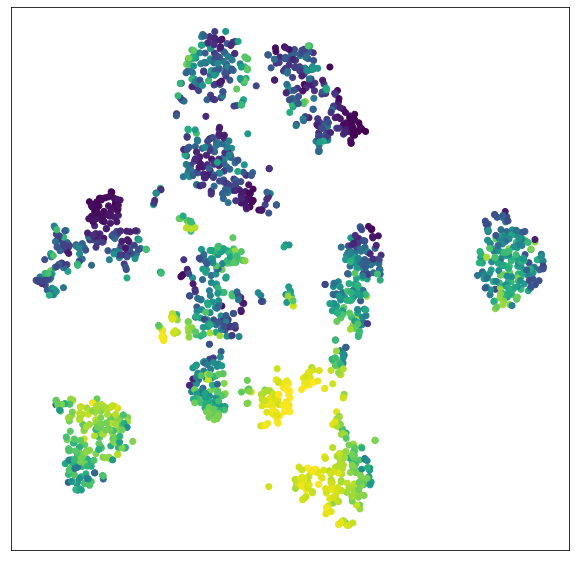

***************************************************************************
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=10,
                        pooling_func='deprecated')
------------------------------ digits ------------------------------
time		NMI		homogeneity		completeness
0.38s		0.796		0.758			0.836


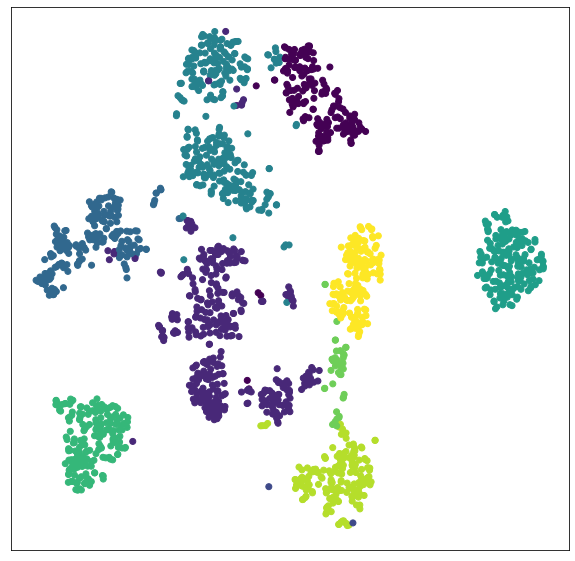

***************************************************************************
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=10,
                        pooling_func='deprecated')
------------------------------ digits ------------------------------
time		NMI		homogeneity		completeness
0.34s		0.014		0.007			0.238


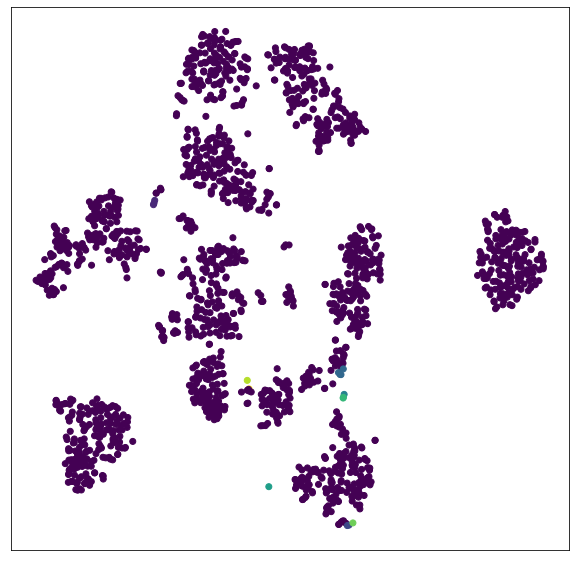

***************************************************************************
DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=1, n_jobs=None, p=None)
------------------------------ digits ------------------------------
time		NMI		homogeneity		completeness
1.02s		0.470		1.000			0.307


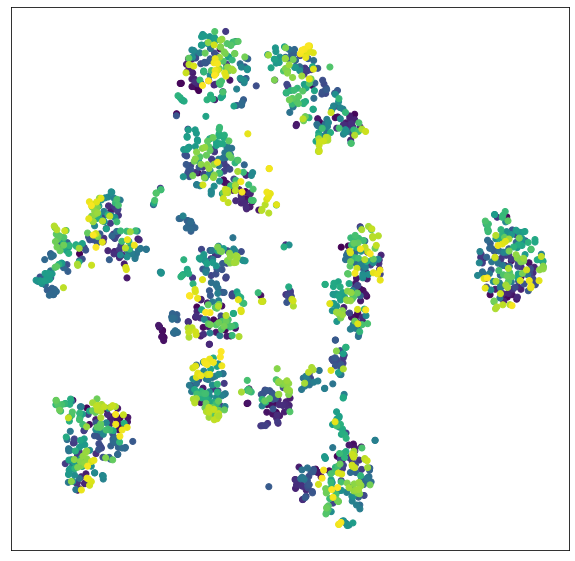

***************************************************************************
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
0.57s		0.612		0.569			0.663


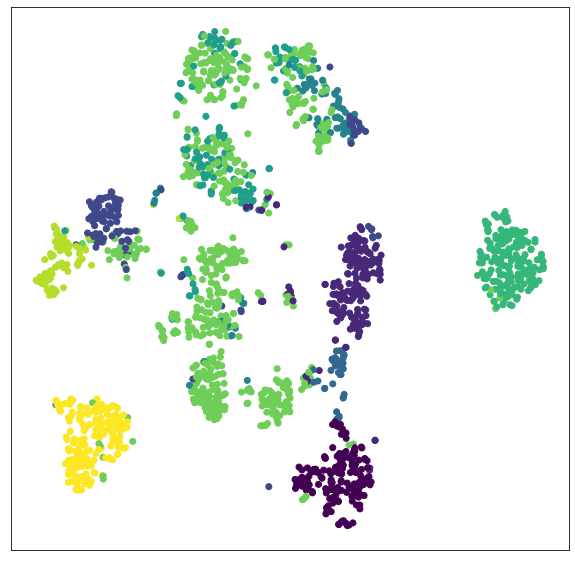

In [8]:
for method in methods:
    if method.__str__()[:3] == "Gau" :
        print(75 * '*')
        print(method)
        print(31*'-'+' news '+31*'-')
        gaussianbench(method, digits_data, digits_labels)
        visualize(digits_data_2d, method.predict(digits_data))
    else:
        print(75 * '*')
        print(method)
        print(30*'-'+' digits '+30*'-')
        bench(method, digits_data, digits_labels)
        visualize(digits_data_2d, method.labels_)

In [9]:
methods = [
    cluster.KMeans(init='k-means++', n_clusters=n_groups),
    cluster.AffinityPropagation(),
    cluster.MeanShift(bandwidth=0.3,min_bin_freq=5),
    cluster.hierarchical.AgglomerativeClustering(n_clusters=n_groups),
    cluster.hierarchical.AgglomerativeClustering(n_clusters=n_groups, linkage='average'),
    cluster.DBSCAN(eps=1,min_samples=1),
    mixture.GaussianMixture(n_components=n_groups),
]

***************************************************************************
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
0.81s		0.251		0.210			0.314


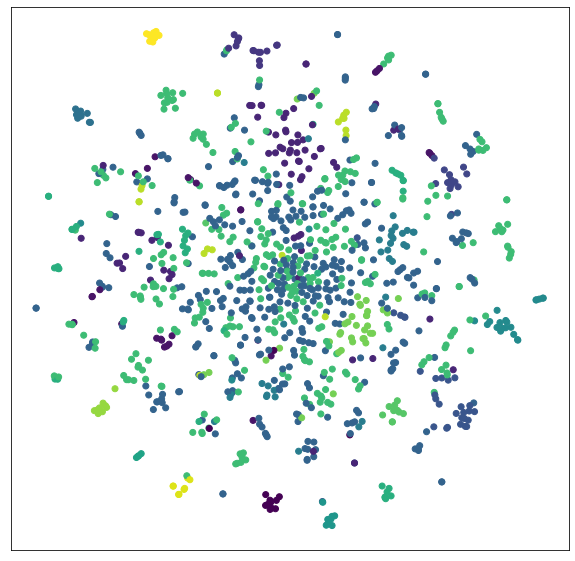

***************************************************************************
AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
9.67s		0.408		0.483			0.354


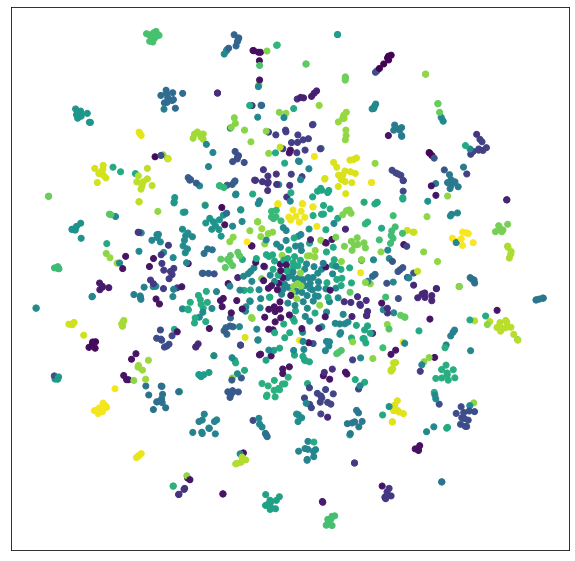

***************************************************************************
MeanShift(bandwidth=0.3, bin_seeding=False, cluster_all=True, min_bin_freq=5,
          n_jobs=None, seeds=None)
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
5.07s		0.000		0.000			1.000


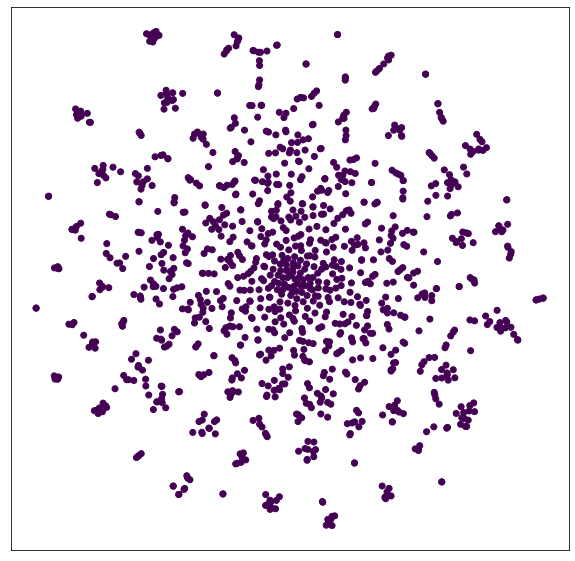

***************************************************************************
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=20,
                        pooling_func='deprecated')
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
0.24s		0.213		0.149			0.376


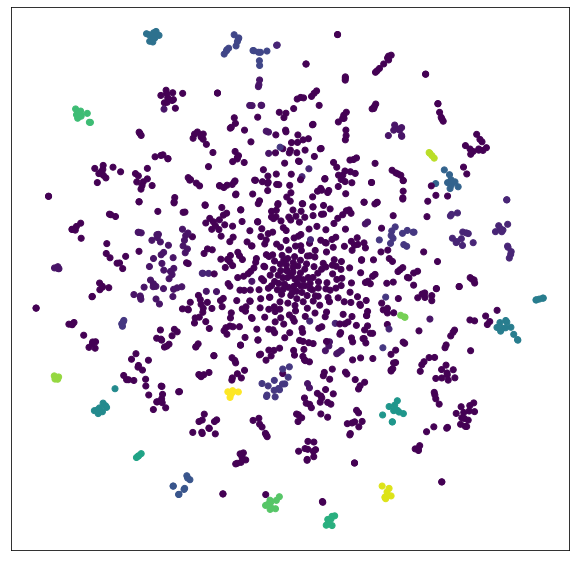

***************************************************************************
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=20,
                        pooling_func='deprecated')
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
0.24s		0.070		0.038			0.401


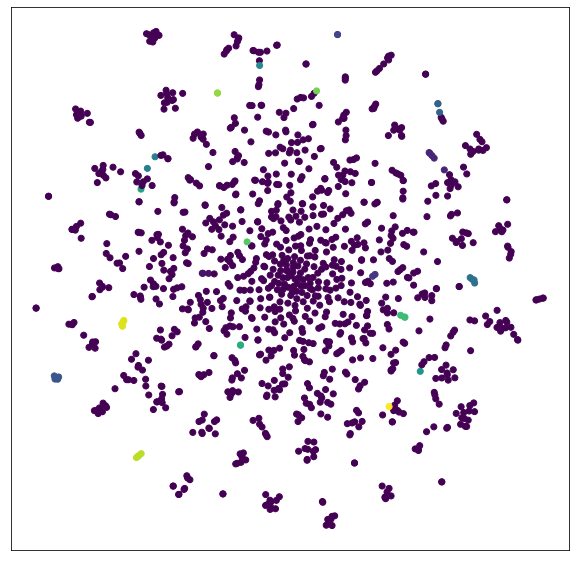

***************************************************************************
DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=1, n_jobs=None, p=None)
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
0.07s		0.000		0.000			1.000


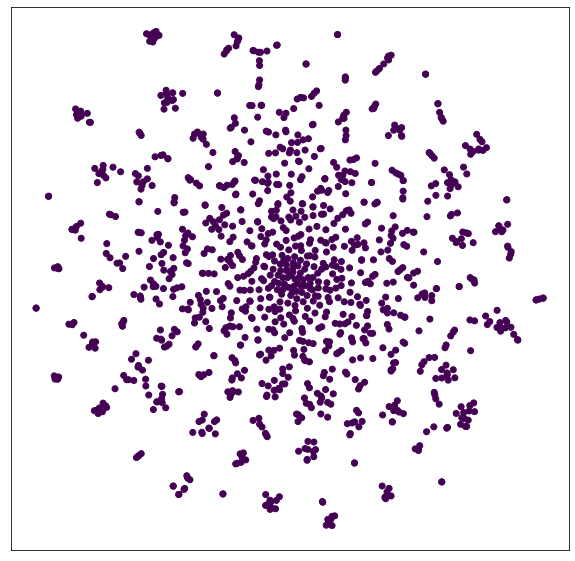

***************************************************************************
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=20, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)
------------------------------- news -------------------------------
time		NMI		homogeneity		completeness
1.13s		0.201		0.145			0.329


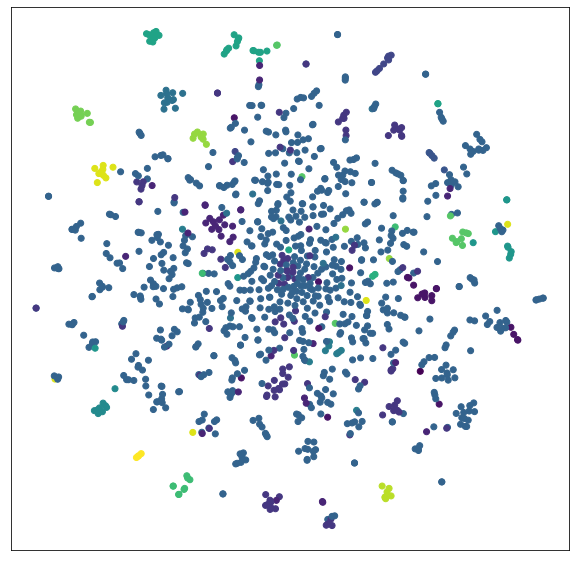

In [10]:
for method in methods:
    if method.__str__()[:3] == "Gau" :
        print(75 * '*')
        print(method)
        print(31*'-'+' news '+31*'-')
        gaussianbench(method, news_data, news_labels)
        visualize(news_data_2d, method.predict(news_data))
    else:
        print(75 * '*')
        print(method)
        print(31*'-'+' news '+31*'-')
        bench(method, news_data, news_labels)
        visualize(news_data_2d, method.labels_)